In [1]:
import torch
import torch.nn.functional as F
import pytorch3d.transforms as T3

In [14]:
def make_kmat(v):
    kmat = torch.zeros(v.size(0), 3, 3, device=v.device)
    kmat[:, 0, 1] = -v[:, 2]
    kmat[:, 0, 2] =  v[:, 1]

    kmat[:, 1, 0] =  v[:, 2]
    kmat[:, 1, 2] = -v[:, 0]

    kmat[:, 2, 0] = -v[:, 1]
    kmat[:, 2, 1] =  v[:, 0]
    return kmat

def get_rotation_matrix(vec):
    bs, device = vec.size(0), vec.device
    a = torch.tensor([0., 0., 1.], device=device).expand_as(vec)
    b = F.normalize(vec, dim=-1)
    v = torch.cross(a, b, dim=-1)    
    c = (a * b).sum(dim=-1)    
    s = torch.norm(v, dim=-1)    
    kmat = make_kmat(v)    
    eye = torch.eye(3, device=device)[None].expand(bs, -1, -1)    
    mult = ((1- c) / (s ** 2)).reshape(bs, 1, 1)
    rotation_matrix = eye + kmat + torch.bmm(kmat, kmat) * mult
    return rotation_matrix

def get_min_max(points):
    return (points.min(dim=1).values,
            points.max(dim=1).values)


def align(points, normals):
    device = points.device
    # Rotate points
    vec = F.normalize(normals.mean(dim=1), dim=-1)
    rot_mat = get_rotation_matrix(vec)
    RT = T3.Rotate(rot_mat, device=device)
    t_points = RT.transform_points(points)
    t_normals = RT.transform_normals(normals)

    # Translate points
    tm = t_points.mean(dim=-2, keepdim=False)
    T = T3.Translate(-tm, device=points.device)            
    t_points = T.transform_points(t_points)

    # Scale points
    min_vals, max_vals = get_min_max(t_points)
    tm = (min_vals + max_vals) / 2
    sm = torch.zeros_like(tm) + (1. / (max_vals - min_vals)[:, :2]).min()        
    ST = T3.Scale(sm, device=points.device)
    t_points = ST.transform_points(t_points)
    t_normals = ST.transform_normals(normals)

    return t_points, t_normals
    
    
        

In [3]:
import math
import time
import matplotlib.pyplot as plt
import torch
import trimesh

from pytorch3d.structures import (
    Pointclouds,
    Meshes,
)

import torch
import torch.nn.functional as F
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.io import load_obj
from pytorch3d.structures import (
    Pointclouds,
    Meshes,
)
from pytorch3d.renderer.blending import BlendParams
from pytorch3d.renderer import TexturesVertex
from src.render.points_renderer import PointsRenderer
from src.config import get_parser
from src.blueprint_sampler import BlueprintSampler
src.utilities.util import grid_to_list
torch.set_printoptions(sci_mode=False
)

import pytorch3d.transforms as T3

In [17]:
# Set the cuda device
device = torch.device("cuda:0")
torch.cuda.set_device(device)

bs = 2
    
config = get_parser().parse_args(args=[])

config.raster_image_size = 512
config.raster_radius = 0.012
config.raster_points_per_pixel = 4
    
d_size = 1024
config.data_blueprint = f'blueprint_radial_{d_size}.npz'
config.data_blueprint_size = d_size
config.data_patch_size = d_size // 5
config.raster_max_brightness = 0.9
#parser.add_argument('--raster_blur_radius', type=float, default=0.01)
#parser.add_argument('--raster_faces_per_pixel', type=int, default=4)

blueprintSampler = BlueprintSampler(config)
res = blueprintSampler(bs)
points = res['points']
normals = res['normals']
faces = res['faces']

points = grid_to_list(points).to(device)
normals = grid_to_list(normals).to(device)
#faces = faces.to(device)

points.shape, normals.shape, faces.shape

(torch.Size([2, 41616, 3]),
 torch.Size([2, 41616, 3]),
 torch.Size([2, 82418, 3]))

In [5]:
config.raster_blur_radius = 0.0
config.raster_faces_per_pixel = 4
R = PointsRenderer(config)
R.setup(device)
R = R.to(device)

torch.Size([2, 512, 512, 3])


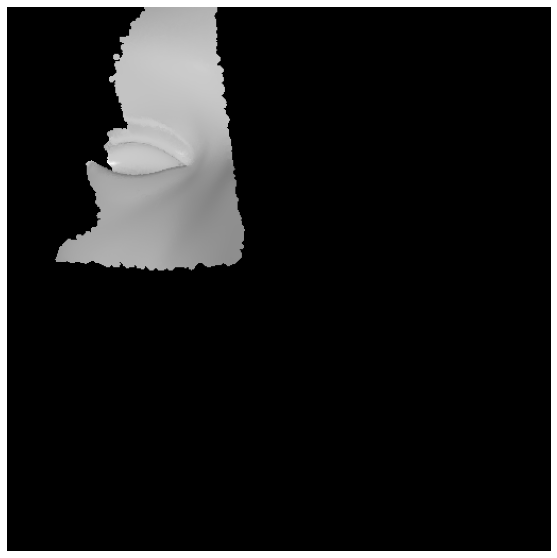

In [20]:
images = R(points, normals, translate=False)
print(images.shape)

plt.figure(figsize=(10, 10))
plt.imshow(images[1, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

torch.Size([2, 512, 512, 3])


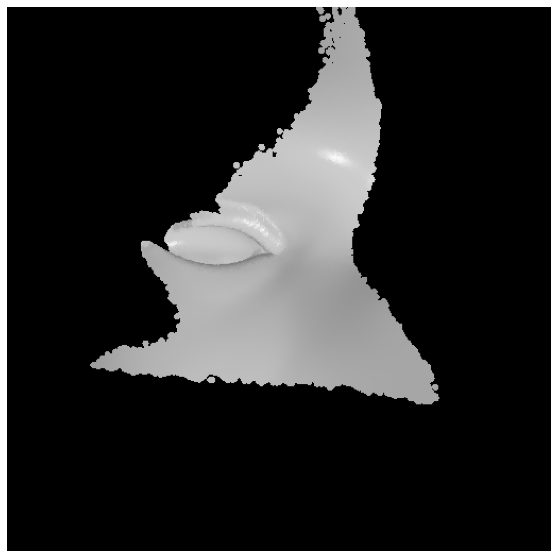

In [21]:
t_points, t_normals =  align(points, normals)
images = R(t_points, t_normals, translate=False)
print(images.shape)

plt.figure(figsize=(10, 10))
plt.imshow(images[1, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");